**Problem background:**
- Pneumonia is an infection in one or both lungs. Bacteria, viruses, and fungi cause it.
-	Infection causes Inflammation in the air sacs (alveoli)  in your lungs 
-	Alveoli,  take up the oxygen you breathe in and keep your body going. Although they’re microscopic, alveoli are the workhorses of your respiratory system.
-	480 million alveoli, located at the end of bronchial tubes. When you breathe in, the alveoli expand to take in oxygen. When you breathe out, the alveoli shrink to expel carbon dioxide.
- following test are performed for the diagonis 
  - Chest X-ray / CT scan
  - Blood test
  - Bronchoscope
  
- Pneumonia can affect anyone. But the two age groups at highest risk are:

  - Children who are 2 years old or younger
  - People who are age 65 or older

  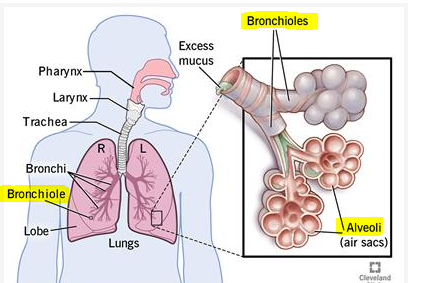

  


**Problem Statement**- Pneumonia detection 

**Why ?**
 - Diagnosis is a complex process and requred a highely trained specialist 
 - Cost informed in the diagnosis

**What ?** 
  - Create a ML model which read the CXR images and locate the postion of the inflammation 

**How ?**

 - Approach - 1 ( Feature extraction ( DNN ) + Classification ( ML )
  - stacking models - Image classification ( to check is affected by Pneumonia or not ) and If the patient affected by Pneumonia then inputs are passed to second model to locate the inflammation
 - Approach 2 - Single model to locate the inflammation. ( Automl - autogluon , tensorflow - objectdetection )  

 - Metrics - Recall will be the evaluation metrics ( Since it's important to indentify the person affected by Pneumonia )

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing lib

In [2]:
pip install pydicom

     |████████████████████████████████| 1.9 MB 7.6 MB/s 


In [30]:
import pandas as pd
import numpy as np
import os
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import cv2


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image,ImageDraw,ImageOps


### setting folder path

In [31]:
DATA_ROOT_PATH = "/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/"
META_DATA = os.path.join(DATA_ROOT_PATH,"stage_2_detailed_class_info.csv/stage_2_detailed_class_info.csv")
TRAIN_LABEL = os.path.join(DATA_ROOT_PATH,"stage_2_train_labels.csv/stage_2_train_labels.csv")
TRAIN_FOLDER = os.path.join(DATA_ROOT_PATH,"stage_2_train_images")
TEST_FOLDER = os.path.join(DATA_ROOT_PATH,"stage_2_test_images")

DATA_ROOT_PATH,META_DATA, TRAIN_LABEL,TRAIN_FOLDER,TEST_FOLDER

('/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_detailed_class_info.csv/stage_2_detailed_class_info.csv',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_train_labels.csv/stage_2_train_labels.csv',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_train_images',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/stage_2_test_images')

### Reading Data

In [32]:
meta_data = pd.read_csv(META_DATA)
meta_data.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [33]:
train_data = pd.read_csv(TRAIN_LABEL)
train_data.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


### Exploratory data analysis

#### checking data distribution

Shape of data (26684, 2)
----------------

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64
----------------



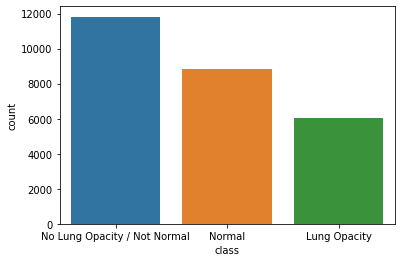

In [34]:
### Distribution od the class
meta_data.drop_duplicates(inplace=True)
print("Shape of data",meta_data.shape)
print("----------------\n")

print(meta_data["class"].value_counts())
print("----------------\n")

sns.countplot(data=meta_data,x="class")

Shape of data (30227, 6)
----------------

0    20672
1     9555
Name: Target, dtype: int64
----------------



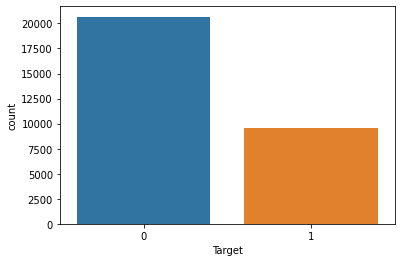

In [35]:
### Distribution of the class
train_data.drop_duplicates(inplace=True)
print("Shape of data",train_data.shape)
print("----------------\n")

print(train_data["Target"].value_counts())
print("----------------\n")

sns.countplot(data=train_data,x="Target")

In [36]:
train_data = train_data.join(meta_data.set_index("patientId"),on="patientId")
print("Shape after merge", train_data.shape)
train_data.head()

Shape after merge (30227, 7)


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


#### prepare file name list

In [37]:
train_img_list = os.listdir(TRAIN_FOLDER)
print("Total train image",len(train_img_list))

test_img_list = os.listdir(TEST_FOLDER)
print("Total train image",len(test_img_list))


train_file_ext = set()
for train_img in train_img_list:
  _,extension = os.path.splitext(train_img)
  train_file_ext.add(extension)


test_file_ext = set()
for test_img in test_img_list:
  _,extension = os.path.splitext(test_img)
  test_file_ext.add(extension)  


print("Available file extension on train", train_file_ext)
print("Available file extension on test", test_file_ext)



Total train image 26694
Total train image 3000
Available file extension on train {'.dcm'}
Available file extension on test {'.dcm'}


#### Update file path to pandas

In [38]:
patientId_list = []
file_path_list = []
train_test_label = []

for filename in train_img_list:
  patientid,extension = os.path.splitext(filename)
  patientId_list.append(patientid)
  file_path_list.append(os.path.join(TRAIN_FOLDER,filename))
  train_test_label.append("Train")


for filename in test_img_list:
  patientid,extension = os.path.splitext(filename)
  patientId_list.append(patientid)
  file_path_list.append(os.path.join(TEST_FOLDER,filename))
  train_test_label.append("Test")


print("length of list ",len(patientId_list),len(file_path_list) )

file_data = pd.DataFrame(columns=["patientId","filepath"])
file_data["patientId"] = patientId_list
file_data["filepath"] = file_path_list
file_data["Train_or_Test"] = train_test_label
print("file Path dataframe shape",file_data.shape)
file_data.head()



length of list  29694 29694
file Path dataframe shape (29694, 3)


,patientId,filepath,Train_or_Test
0,f7661af4-f66e-4867-a3d6-7e1fab5aabb2,/content/drive/MyDrive/GreatLearning/Captone_p...,Train
1,f7b557b1-623e-4466-a60b-ada96f7ba8ff,/content/drive/MyDrive/GreatLearning/Captone_p...,Train
2,f7a60085-3653-4011-b420-ed3a92a4a80a,/content/drive/MyDrive/GreatLearning/Captone_p...,Train
3,f79bfdae-858b-404b-b25f-7acf681804da,/content/drive/MyDrive/GreatLearning/Captone_p...,Train
4,f7909c0c-c9f0-4c93-be7f-113926850ac3,/content/drive/MyDrive/GreatLearning/Captone_p...,Train


In [39]:
train_data = train_data.join(file_data.set_index("patientId"),on="patientId")
print("Shape of dataframe after merge",train_data.shape)
train_data.head()

Shape of dataframe after merge (30227, 9)


,patientId,x,y,width,height,Target,class,filepath,Train_or_Test
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/content/drive/MyDrive/GreatLearning/Captone_p...,Train


In [ ]:
# file_name = os.path.join(TRAIN_FOLDER,train_img_list[20])
# ds = dicom.read_file(file_name)
# ds.PatientSex,ds.PatientAge,ds.ViewPosition,ds.PatientID

('M', '60', 'AP', 'f7963c46-8d6f-43c0-bfb1-b7d41dd0cc6c')

#### visualization of xray with bounding box

In [40]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    img = dicom.dcmread(path)    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(img.pixel_array, img)
    else:
        data = img.pixel_array               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and img.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)        
    return data

In [49]:
# Visualize the image 
infected_id = train_data.query("Target == 1").sample(n=9).index
not_infected_id = train_data.query("Target == 0").sample(n=9).index


def plot_images(id_list):
  plt.figure(figsize=(10, 10))
  for i in range(9):  
      index =  id_list[i]  
      file_name = train_data.iloc[index]["filepath"]
      #print(index)
      img = read_xray(file_name)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(img,"bone")
      if str(train_data.iloc[index]["Target"]) == "1":
        x = int(train_data.iloc[index]["x"])
        y = int(train_data.iloc[index]["y"])
        width = int(train_data.iloc[index]["width"])
        height = int(train_data.iloc[index]["height"])
        #print(int(x),int(y),(int(x+width), int(y+height)))
        rect = Rectangle((x,y), width,height, linewidth=2, fill=False,color="red")
        ax.add_patch(rect)
      plt.title(train_data.iloc[index]["class"] +" Target --"+str(train_data.iloc[index]["Target"]) )
      #plt.axis("off")
  plt.show()    


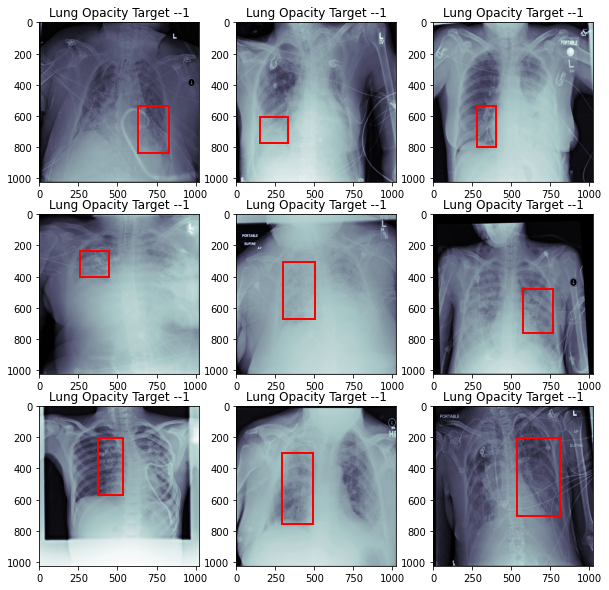

In [50]:
plot_images(infected_id)

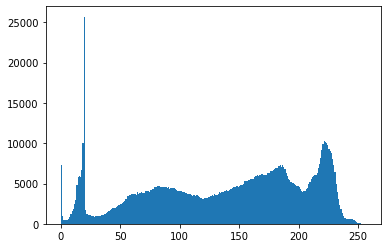

(0, 255)

In [70]:

file_name = train_data.iloc[8351]["filepath"]
#test_img = dicom.read_file(file_name).pixel_array
test_img = read_xray(file_name)
#test_img.shape
#test_img = test_img.astype(float)
#test_img = (np.maximum(test_img,0) / test_img.max()) * 255.0
#test_img = np.uint8(test_img)

#histr = cv2.calcHist([test_img],[0],None,[256],[0,256])


#plt.hist(test_img.ravel(),  range=(0.0, 1.0), fc='k', ec='k') #calculating histogram
#plt.plot(histr)
plt.hist(test_img.ravel(),256,[0,256])

plt.show()
test_img.min(),test_img.max()


In [71]:
uniform_data = np.random.rand(10, 12)
uniform_data.shape

(10, 12)

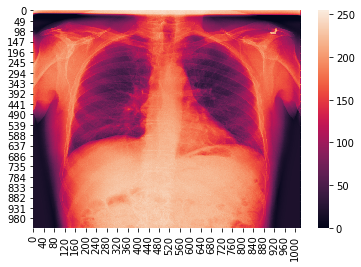

In [72]:
sns.heatmap(test_img)

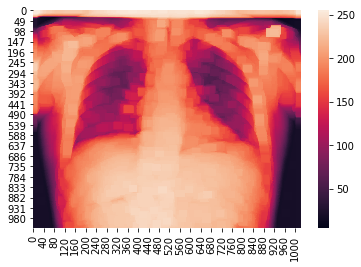

In [99]:
import tensorflow as tf 
from tensorflow.keras.layers import MaxPool2D  
x = tf.reshape(test_img, [1, 1024, 1024, 1])

max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(32,32),strides=(1, 1), padding='same')

x1 = max_pool_2d(x)


x1 = np.reshape(x1, (x1.shape[1],x1.shape[2]))
sns.heatmap(x1)

#### Age / sex and its correlation with infection

In [ ]:
# Visualize the image 
infected_id = train_data.query("Target == 1").sample(n=100).index
not_infected_id = train_data.query("Target == 0").sample(n=100).index



def read_xray_metadata(id_list):
  data_list = []
  for index in id_list:
    file_name = train_data.iloc[index]["filepath"]
    ds = dicom.read_file(file_name)
    data = []
    data.append(ds.PatientID)
    data.append(ds.PatientAge)
    data.append(ds.PatientSex)
    data_list.append(data)
    #print(train_data.iloc[index]["patientId"],ds.PatientID)
  return data_list


result_list = []
result_list.extend(read_xray_metadata(infected_id))
result_list.extend(read_xray_metadata(not_infected_id))

sample_meta_data = pd.DataFrame(result_list,columns=["patientId","age","sex"])
sample_meta_data = sample_meta_data.join(train_data[["patientId","Target"]].drop_duplicates().set_index("patientId"),on="patientId")
print("shape", sample_meta_data.shape)
sample_meta_data.head(20)

shape (200, 4)


,patientId,age,sex,Target
0,a70544fd-cd5f-4650-9008-224672ccd7b6,33,M,1
1,a21dc214-0756-48ec-9b5b-16ca1bb243b0,21,M,1
2,980bedbf-2f34-4596-a7cb-ec66fd1ec4de,69,F,1
3,f7250628-0db8-4baa-adbf-fd694cbd3b7d,15,M,1
4,0d45f420-10d0-41a2-9b87-f5ea81c28599,33,F,1
5,23997b8b-5726-4b2d-bd45-b15fc1c4c2af,22,M,1
6,be653a8a-5978-48b3-9101-91e35a15e6d2,56,F,1
7,5b72c6d2-e7eb-44a6-b625-78d2ec0008f2,46,M,1
8,a99561a5-2c12-48cd-be57-ce6b6cf58da1,58,M,1
9,b406e391-9f28-4f26-a71f-285d5e3f488c,58,F,1


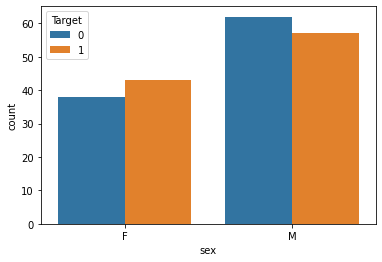

In [ ]:
sns.countplot(data=sample_meta_data,x="sex",hue="Target")

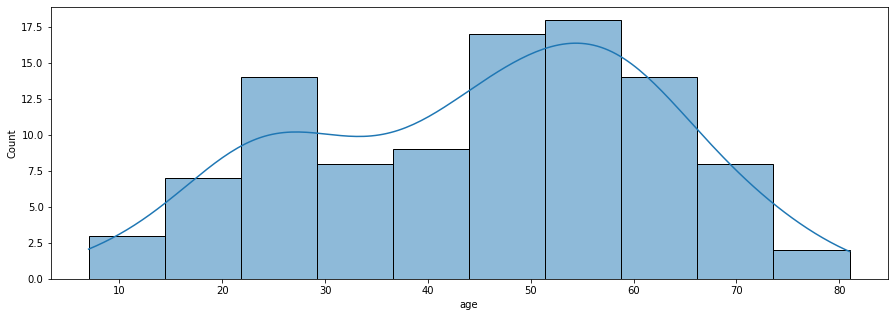

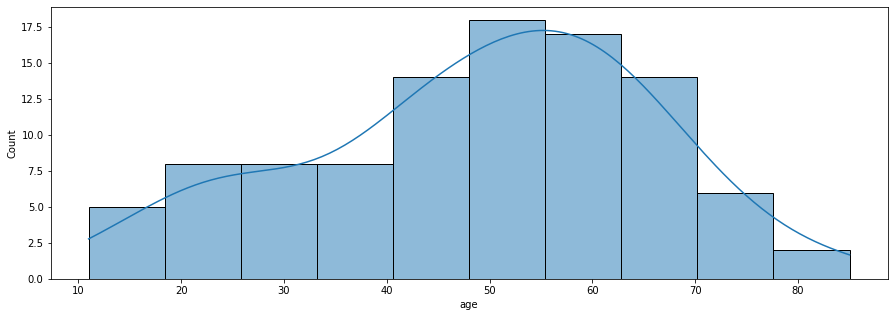

In [ ]:
sample_meta_data.age = sample_meta_data.age.astype(int)
sample_meta_data.sort_values(by=["age"],inplace=True)

fig,ax = plt.subplots(figsize=(15,5))
sns.histplot(data = sample_meta_data.query("Target ==1"),x="age",kde=True,ax=ax,bins=10)
plt.show()

fig,ax = plt.subplots(figsize=(15,5))
sns.histplot(data = sample_meta_data.query("Target ==0"),x="age",kde=True,ax=ax,bins=10)
plt.show()


In [ ]:
sample_meta_data

,patientId,age,sex,Target
0,7358decc-5bb3-4fad-8eab-c3c6459d2c11,65,F,1
0,7358decc-5bb3-4fad-8eab-c3c6459d2c11,65,F,1
1,bd88f2af-7d9f-44a8-8004-ea76250dc9b2,30,F,1
1,bd88f2af-7d9f-44a8-8004-ea76250dc9b2,30,F,1
2,2397b2f6-3dfa-476c-89ea-e9992c5bd9a9,57,F,1
2,2397b2f6-3dfa-476c-89ea-e9992c5bd9a9,57,F,1
3,469ee828-7b1a-436b-accb-f928582d1330,35,M,1
3,469ee828-7b1a-436b-accb-f928582d1330,35,M,1
4,30d3d2f9-4342-4ab4-9032-34d894c2cfbb,84,M,1
4,30d3d2f9-4342-4ab4-9032-34d894c2cfbb,84,M,1
